In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import json
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
from PIL import Image
import albumentations as alb

In [2]:
# CONSTANTS
class Config:
    NUM_CLASSES = 5
    BATCH_SIZE = 16
    NUM_FOLDS = 5
    UNFREEZE_EPOCH_NO = 1
    NUM_EPOCHS = 1
    NUM_WORKERS = 8
    INPUT_IMAGE_SIZE = (224,224)
    IMG_MEAN = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225]
    FAST_DEV_RUN = True
    PRECISION = 16
    IMG_ROOT_FOLDER = "./data/"
    PATIENCE = 5

class TransformationType:
    TORCHVISION = "torchvision"
    ALB = "albumentations"

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"    

## EDA

In [3]:
with open(Config.IMG_ROOT_FOLDER + "label_num_to_disease_map.json") as label_mapping_file:
    label_map = json.load(label_mapping_file)

In [4]:
df_train_img_names = pd.read_csv(Config.IMG_ROOT_FOLDER + "train.csv")
# Add a column with disease name
df_train_img_names["disease"] = df_train_img_names.apply(
    lambda row: label_map[str(row["label"])], axis=1
    )
df_train_img_names.head()

,image_id,label,disease
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [5]:
df_train_img_names.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

Check the disease distribution within the training samples. Distribution doesn't seem balanced with CMD outnumbering other disease types by a wide margin

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: disease, dtype: int64


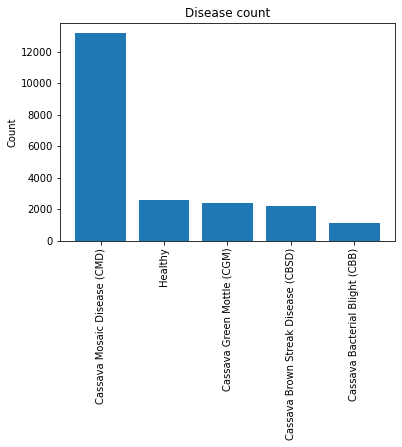

In [6]:
# Disease distribution
disease_counts = df_train_img_names.disease.value_counts()
print(disease_counts)
plt.bar(disease_counts.index, disease_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Disease count")
plt.show()


In [7]:

# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified kfold if the target distribution is unbalanced
def strat_kfold_dataframe(df, target_col_name, num_folds=5):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y)):
        df.loc[val_index, "kfold"] = fold    
    return df     

df_train_img_names = strat_kfold_dataframe(df_train_img_names, target_col_name="label")
df_train_img_names.head()

,image_id,label,disease,kfold
0,2615227158.jpg,4,Healthy,2
1,1277648239.jpg,3,Cassava Mosaic Disease (CMD),1
2,2305895487.jpg,3,Cassava Mosaic Disease (CMD),2
3,336299725.jpg,2,Cassava Green Mottle (CGM),1
4,1951270318.jpg,2,Cassava Green Mottle (CGM),0


In [8]:
import tqdm

# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html
# https://www.thoughtco.com/sum-of-squares-formula-shortcut-3126266
def get_imgs_mean_stddev(dl_img, axis=None):    
    """Get the mean and standard deviation for images in a dataset / mini-batch.
    img batch is of shape BS * C * H * W 
    where BS = batch_size or no of training samples 
    C = 3 ( RGB channels ), H = height of image matrix, W = width of image matrix
    Args:
        dl_imgs ([DataLoader]): image data loader
        axis ([tuple of ints], optional): Axis along which mean and std dev is to be calculated.
        Defaults to None.
    Returns:
        [tuple]: tuple of tensors with mean and std.dev. of the imgs
    """
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # sum of pixel values along RGB channels
    psum = torch.Tensor([0.0, 0.0, 0.0])
    # sum of squares of pixel values along RGB channels
    psum_sq = torch.Tensor([0.0, 0.0, 0.0])        
    num_img = 0    
    img_h, img_w = 0, 0    
    count = 0
    for img, label in tqdm.tqdm(dl_img): 
        if count == 0:            
            img_h = img.shape[2]       
            img_w = img.shape[3]
        num_img += img.shape[0]            
        psum += img.sum(axis=[0, 2, 3])        
        img_sq = img.square()
        psum_sq += img_sq.sum(axis=[0, 2, 3])
        count += 1
    # pixel count of single img (index 1 is the height and index 2 is width of img)
    img_pixel_count = img_h * img_w      
    total_pixel_count = num_img * img_pixel_count   
    # mean of pixel values across the dataset        
    total_mean = psum / total_pixel_count    
    # variance of pixel values across the dataset
    total_var = (psum_sq / total_pixel_count) - (total_mean.square())    
    total_std = torch.sqrt(total_var)
    return total_mean, total_std

# Define a custom pytorch Dataset for training

In [9]:
# A dataset contains the logic to fetch, load and if required transform data to bring it to a format
# that can be used by dataloaders for training
class CassavaImageDataset(Dataset):
    def __init__(self, df, img_name_col, target_col, img_root_folder, transform=None, target_transform=None):
        self.df = df
        self.img_name_col = img_name_col
        self.target_col = target_col
        self.img_root_folder = img_root_folder
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_path = self.img_root_folder + "/" + self.df.loc[index, self.img_name_col]
        img = np.array(Image.open(img_path))
        img_label = self.df.loc[index, self.target_col]
        if self.transform is not None:
            augmented = self.transform(image=img)
            img = augmented["image"]
        if self.target_transform is not None:
            img_label = self.target_transform(img_label)
        return img, img_label

    def __len__(self):
        return len(self.df)

In [10]:
from albumentations.pytorch import ToTensorV2

train_transform = alb.Compose([
        alb.RandomResizedCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),        
        alb.Transpose(p=0.5),                
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.ShiftScaleRotate(p=0.5),
        alb.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),        
        alb.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()
])

val_transform = alb.Compose([
        alb.CenterCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()        
])

In [11]:
def get_fold_dls(fold, df_imgs):
    df_train = df_imgs[df_imgs["kfold"] != fold].reset_index(drop=True)
    df_val = df_imgs[df_imgs["kfold"] == fold].reset_index(drop=True)    
    ds_train = CassavaImageDataset(
        df_train, 
        img_name_col="image_id",
        target_col="label",
        img_root_folder=Config.IMG_ROOT_FOLDER + "train_images", 
        transform=train_transform,
        target_transform=torch.as_tensor
        )
    ds_val = CassavaImageDataset(
        df_val, 
        img_name_col="image_id",
        target_col="label",
        img_root_folder=Config.IMG_ROOT_FOLDER + "train_images", 
        transform=val_transform,
        target_transform=torch.as_tensor
        )        
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)    
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [12]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, df_train_img_names)

In [13]:
# counter = 0
# for imgs, lbls in dl_val:
#     if counter > 0:
#         break
#     img_mean = torch.mean(imgs, axis=(0, 2, 3))
#     img_std = torch.std(imgs, axis=(0, 2, 3))
#     counter += 1
# print(img_mean, img_std)    

In [14]:
# ds_all = CassavaImageDataset(
#         df_train_img_names, 
#         img_name_col="image_id",
#         target_col="label",
#         img_root_folder="./data/train_images", 
#         transform=train_transform,
#         target_transform=torch.as_tensor
#         )
# dl_all = DataLoader(ds_all, batch_size=BATCH_SIZE, shuffle=True)            
# img_mean, img_std = get_imgs_mean_stddev(dl_all)
# print(f"img mean calculated on entire training dataset = {img_mean}")
# print(f"img std calculated on entire training dataset = {img_std}")

img mean calculated on entire training dataset = tensor([0.4303, 0.4967, 0.3135])<br>
img std calculated on entire training dataset = tensor([0.2203, 0.2232, 0.2114])

In [15]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

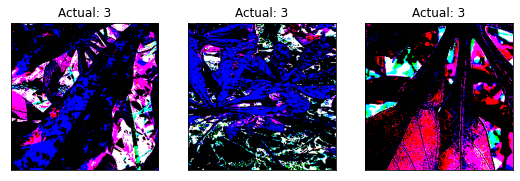

In [16]:
show_batch(ds_val, 3, 1, 3)

In [17]:
# from typing import Optional
# from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

# class CassavaDataModule(pl.LightningDataModule):
#     def __init__(self, fold, img_root_path, df, img_name_col, target_col, batch_size=BATCH_SIZE,  
#                  input_img_dims=(3,INPUT_IMAGE_SIZE[0],INPUT_IMAGE_SIZE[1]),num_target_classes=5, 
#                  train_transforms=None, val_transforms=None):  
#         super().__init__()                       
#         self.fold = fold
#         self.img_root_path = img_root_path  
#         self.df = df
#         self.img_name_col = img_name_col
#         self.target_col = target_col
#         self.batch_size = batch_size
#         self.input_imgs_dims = input_img_dims        
#         self.num_target_classes = num_target_classes        
#         if train_transforms is None:
#             self.train_transforms = None
#         else:
#             self.train_transforms = train_transforms    

#         if val_transforms is None:
#             self.val_transforms = None
#         else:
#             self.val_transforms = val_transforms                        

#     def prepare_data(self) -> None:
#          return super().prepare_data()       

#     def setup(self, stage: Optional[str] = None) -> None:
#         super().setup(stage=stage)                     
#         self.df_train = self.df[self.df["kfold"] != self.fold].reset_index(drop=True)
#         self.df_val = self.df[self.df["kfold"] == self.fold].reset_index(drop=True)  
#         self.ds_train = CassavaImageDataset(
#             self.df_train, 
#             img_name_col=self.img_name_col,
#             target_col=self.target_col,
#             img_root_folder=self.img_root_path, 
#             transform=self.train_transforms,
#             target_transform=torch.as_tensor
#             )
#         self.ds_val = CassavaImageDataset(
#             self.df_val, 
#             img_name_col=self.img_name_col,
#             target_col=self.target_col,
#             img_root_folder=self.img_root_path, 
#             transform=self.val_transforms,
#             target_transform=torch.as_tensor
#             )            

#     def train_dataloader(self) -> TRAIN_DATALOADERS:
#         return DataLoader(self.ds_train, batch_size=self.batch_size, shuffle=True, 
#                             num_workers=NUM_WORKERS)            

#     def val_dataloader(self) -> EVAL_DATALOADERS:
#         return DataLoader(self.ds_val, batch_size=self.batch_size, num_workers=NUM_WORKERS)            

In [18]:
# img_name_col="image_id"
# target_col="label"
# img_root_folder="./data/train_images"

# dm = CassavaDataModule(
#     fold = 0, 
#     df = df_train_img_names,
#     img_root_path = img_root_folder,
#     img_name_col = img_name_col,
#     target_col = target_col,
#     train_transforms = train_transform,
#     val_transforms = val_transform
#     )

In [19]:
import torchvision.models as models
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy
import timm

class ImageClassificationLitModel(pl.LightningModule):
    def __init__(self, num_classes, hparams, model_to_use):
        super().__init__()
        self.save_hyperparameters()
        self.lr = hparams["lr"]
        self.num_classes = num_classes        
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, hparams["drop_out"], num_classes) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

    def configure_optimizers(self):
        model_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, "min")        
        return {
            "optimizer": model_optimizer, 
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        val_acc = accuracy(y_pred, y)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return {"loss": val_loss, "val_acc": val_acc}

In [20]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(42, workers=True)

# model hyperparameters
model_params = {    
    "drop_out": 0.25,
    "lr": 0.001
    }

Global seed set to 42


In [21]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback

class MetricsAggCallback(Callback):
    def __init__(self, metric_to_monitor, mode):
        self.metric_to_monitor = metric_to_monitor
        self.metrics = []
        self.best_metric = None
        self.mode = mode
        self.best_metric_epoch = None

    def on_epoch_end(self, trainer: Trainer, pl_module: LightningModule):
        metric_value = trainer.callback_metrics[self.metric_to_monitor].cpu().detach().item()
        print(f"metric {self.metric_to_monitor} = {metric_value}")
        self.metrics.append(metric_value)
        if self.mode == "max":
            self.best_metric = max(self.metrics)
            self.best_metric_epoch = self.metrics.index(self.best_metric)
        

In [22]:
from pl_bolts.callbacks import PrintTableMetricsCallback

def run_training(fold, dl_train, dl_val, fold_loss, fold_acc, find_lr=True):
        fold_str = f"fold{fold}"
        print(f"Running training for {fold_str}")
        tb_logger = None
        chkpt_file_name = "best_model_{epoch}_{val_loss:.4f}"        
        multiplicative = lambda epoch: 1.5
        backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=True)
        early_stopping_callback = EarlyStopping(monitor="val_loss", patience=Config.PATIENCE, mode="min", verbose=True)
        #print_table_metric_cb = PrintTableMetricsCallback()
        if fold is not None:       
            chkpt_file_name = fold_str + "_" + chkpt_file_name
            tb_logger = pl.loggers.TensorBoardLogger(save_dir="logs", version=fold_str)
        else:
            tb_logger = pl.loggers.TensorBoardLogger(save_dir="logs")        
        cassava_model = ImageClassificationLitModel(
            num_classes=Config.NUM_CLASSES, 
            hparams=model_params,        
            model_to_use=Models.RESNET50
            )    
        loss_chkpt_callback = ModelCheckpoint(dirpath="./model", verbose=True, monitor="val_loss", mode="min", filename=chkpt_file_name)
        acc_chkpt_callback = MetricsAggCallback(metric_to_monitor="val_acc", mode="max")
        trainer = pl.Trainer(
            gpus=1,
            # For results reproducibility 
            deterministic=True,
            auto_select_gpus=True,
            progress_bar_refresh_rate=20,
            max_epochs=Config.NUM_EPOCHS,
            logger=tb_logger,
            auto_lr_find=True,    
            precision=Config.PRECISION,    
            weights_summary=None, 
            fast_dev_run=Config.FAST_DEV_RUN,                   
            callbacks=[loss_chkpt_callback, acc_chkpt_callback, backbone_finetuning, early_stopping_callback]
        )
        if find_lr:
            trainer.tune(model=cassava_model, train_dataloaders=dl_train)
            print(cassava_model.lr)
        trainer.fit(cassava_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
        if not Config.FAST_DEV_RUN:
            fold_loss.append(loss_chkpt_callback.best_model_score.cpu().detach().item())
            fold_acc.append(acc_chkpt_callback.best_metric)
            print(f"Loss for {fold_str} = {fold_loss[fold]}, accuracy = {fold_acc[fold]}")
        del trainer, cassava_model, backbone_finetuning, early_stopping_callback, acc_chkpt_callback, loss_chkpt_callback 

In [23]:
find_lr = True
fold_loss = []
fold_acc = []

for fold in range(Config.NUM_FOLDS):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, df_train_img_names)
    run_training(fold, dl_train, dl_val, fold_loss, fold_acc)
    break         

Running training for fold0


/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/tuner/lr_finder.py:207: UserWarning: Skipping learning rate finder since fast_dev_run is enabled.
  rank_zero_warn("Skipping learning rate finder since fast_dev_run is enabled.", UserWarning)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.001


/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

metric val_acc = 0.3125
metric val_acc = 0.3125


IndexError: list index out of range

In [ ]:
# model = ResnetTL_LitModel.load_from_checkpoint("./model/cassava_best_model.ckpt",     
#                                                 num_classes=5)
# model.to("cuda")
# model.eval()

# incorrect = 0
# total = 0
# predicted_labels_incorrect = []
# labels_incorrect = []
# with torch.no_grad():
#     counter=0
#     for imgs, labels in tqdm.tqdm(dm.val_dataloader()):                
#         predicted_cuda_labels = torch.argmax(model(imgs.to("cuda")), dim=1)
#         predicted_labels = predicted_cuda_labels.cpu().detach()
#         total += labels.shape[0]
#         correct_pred = predicted_labels == labels
#         incorrect_pred = ~correct_pred
#         num_incorrect_pred = incorrect_pred.sum()
#         incorrect += int(num_incorrect_pred)
#         if num_incorrect_pred > 0:
#             predicted_labels_incorrect.append(predicted_labels[incorrect_pred].numpy())
#             labels_incorrect.append(labels[incorrect_pred].numpy())
# print(f'Total no. of images in validation set: {total}')
# print(f'Incorrectly classified images in validation set: {incorrect}')
# accuracy = ((total-incorrect) / total) * 100        
# print(f"Accuracy: {accuracy}%")

In [ ]:
# lr_finder = trainer.tuner.lr_find(cassava_model, dm)
# print(lr_finder.suggestion())
# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
